<a href="https://colab.research.google.com/github/Congliu0829/cencus_dnn_caching/blob/master/Census_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import os
import time
from sklearn import preprocessing
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install torch==0.4.1
!pip install torchvision==0.2.2
!pip install Pillow==6.2.2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle
from torch.utils.data.sampler import (SubsetRandomSampler,RandomSampler)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cpu


In [ ]:
full_data = pd.read_csv(
    "/content/adult.csv",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python', skiprows=1,
        na_values="?", dtype={0:int, 1:str, 2:int, 3:str, 4:int, 5: str, 6:str , 7:str ,8:str ,9: str, 10:int, 11:int, 12:int, 13:str,14: str})

print('Dataset size: ', full_data.shape[0])

Dataset size:  32561


In [ ]:
print(full_data.head())
print(full_data.shape)

   Age  Workclass  fnlwgt  ... Hours per week          Country   Target
0   90        "?"   77053  ...             40  "United-States"  "<=50K"
1   82  "Private"  132870  ...             18  "United-States"  "<=50K"
2   66        "?"  186061  ...             40  "United-States"  "<=50K"
3   54  "Private"  140359  ...             40  "United-States"  "<=50K"
4   41  "Private"  264663  ...             40  "United-States"  "<=50K"

[5 rows x 15 columns]
(32561, 15)


In [ ]:
str_list=[] 
for data in [full_data]:
    for colname, colvalue in data.iteritems(): 
        if type(colvalue[1]) == str:
            str_list.append(colname) 
num_list = data.columns.difference(str_list) #seperate str with int in input data

In [ ]:
full_size = full_data.shape[0]
print('Dataset size Before pruning: ', full_size)
for data in [full_data]:
    for i in full_data:
        data[i].replace('NaN', np.nan, inplace=True)
    data.dropna(inplace=True)
real_size = full_data.shape[0]
print('Dataset size after pruning: ', real_size)
print('We eliminated ', (full_size-real_size), ' datapoints')

Dataset size Before pruning:  32561
Dataset size after pruning:  32561
We eliminated  0  datapoints


In [ ]:
full_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,90,"""?""",77053,"""HS-grad""",9,"""Widowed""","""?""","""Not-in-family""","""White""","""Female""",0,4356,40,"""United-States""","""<=50K"""
1,82,"""Private""",132870,"""HS-grad""",9,"""Widowed""","""Exec-managerial""","""Not-in-family""","""White""","""Female""",0,4356,18,"""United-States""","""<=50K"""
2,66,"""?""",186061,"""Some-college""",10,"""Widowed""","""?""","""Unmarried""","""Black""","""Female""",0,4356,40,"""United-States""","""<=50K"""
3,54,"""Private""",140359,"""7th-8th""",4,"""Divorced""","""Machine-op-inspct""","""Unmarried""","""White""","""Female""",0,3900,40,"""United-States""","""<=50K"""
4,41,"""Private""",264663,"""Some-college""",10,"""Separated""","""Prof-specialty""","""Own-child""","""White""","""Female""",0,3900,40,"""United-States""","""<=50K"""


In [ ]:
full_labels = full_data['Target'].copy()
print(full_labels.shape[0])

full_data = full_data.drop(['Target'], axis=1)
print(full_data.shape[0])

# Label Encode Labels
label_encoder = LabelEncoder()
full_labels = label_encoder.fit_transform(full_labels)
print(full_labels[:10])

32561
32561
[0 0 0 0 0 0 0 1 0 1]


In [ ]:
cat_data = full_data.select_dtypes(include=['object']).copy()
other_data = full_data.select_dtypes(include=['int']).copy()
print(cat_data.head())
print(cat_data.shape)
print(other_data.shape)#seperate data by objects and numbers 

   Workclass       Education Martial Status  ...     Race       Sex          Country
0        "?"       "HS-grad"      "Widowed"  ...  "White"  "Female"  "United-States"
1  "Private"       "HS-grad"      "Widowed"  ...  "White"  "Female"  "United-States"
2        "?"  "Some-college"      "Widowed"  ...  "Black"  "Female"  "United-States"
3  "Private"       "7th-8th"     "Divorced"  ...  "White"  "Female"  "United-States"
4  "Private"  "Some-college"    "Separated"  ...  "White"  "Female"  "United-States"

[5 rows x 8 columns]
(32561, 8)
(32561, 6)


In [ ]:
newcat_data = pd.get_dummies(cat_data, columns=[
    "Workclass", "Education", "Country" ,"Relationship", "Martial Status", "Occupation", "Relationship",
    "Race", "Sex"
])# apply a encoder for str catagories

In [ ]:
newcat_data.head()

,"Workclass_""?""","Workclass_""Federal-gov""","Workclass_""Local-gov""","Workclass_""Never-worked""","Workclass_""Private""","Workclass_""Self-emp-inc""","Workclass_""Self-emp-not-inc""","Workclass_""State-gov""","Workclass_""Without-pay""","Education_""10th""","Education_""11th""","Education_""12th""","Education_""1st-4th""","Education_""5th-6th""","Education_""7th-8th""","Education_""9th""","Education_""Assoc-acdm""","Education_""Assoc-voc""","Education_""Bachelors""","Education_""Doctorate""","Education_""HS-grad""","Education_""Masters""","Education_""Preschool""","Education_""Prof-school""","Education_""Some-college""","Country_""?""","Country_""Cambodia""","Country_""Canada""","Country_""China""","Country_""Columbia""","Country_""Cuba""","Country_""Dominican-Republic""","Country_""Ecuador""","Country_""El-Salvador""","Country_""England""","Country_""France""","Country_""Germany""","Country_""Greece""","Country_""Guatemala""","Country_""Haiti""",...,"Relationship_""Not-in-family""","Relationship_""Other-relative""","Relationship_""Own-child""","Relationship_""Unmarried""","Relationship_""Wife""","Martial Status_""Divorced""","Martial Status_""Married-AF-spouse""","Martial Status_""Married-civ-spouse""","Martial Status_""Married-spouse-absent""","Martial Status_""Never-married""","Martial Status_""Separated""","Martial Status_""Widowed""","Occupation_""?""","Occupation_""Adm-clerical""","Occupation_""Armed-Forces""","Occupation_""Craft-repair""","Occupation_""Exec-managerial""","Occupation_""Farming-fishing""","Occupation_""Handlers-cleaners""","Occupation_""Machine-op-inspct""","Occupation_""Other-service""","Occupation_""Priv-house-serv""","Occupation_""Prof-specialty""","Occupation_""Protective-serv""","Occupation_""Sales""","Occupation_""Tech-support""","Occupation_""Transport-moving""","Relationship_""Husband""","Relationship_""Not-in-family""","Relationship_""Other-relative""","Relationship_""Own-child""","Relationship_""Unmarried""","Relationship_""Wife""","Race_""Amer-Indian-Eskimo""","Race_""Asian-Pac-Islander""","Race_""Black""","Race_""Other""","Race_""White""","Sex_""Female""","Sex_""Male"""
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [ ]:
full_data = pd.concat([other_data, newcat_data], axis=1)

In [ ]:
print(full_data.head())

   Age  fnlwgt  Education-Num  ...  Race_"White"  Sex_"Female"  Sex_"Male"
0   90   77053              9  ...             1             1           0
1   82  132870              9  ...             1             1           0
2   66  186061             10  ...             0             1           0
3   54  140359              4  ...             1             1           0
4   41  264663             10  ...             1             1           0

[5 rows x 114 columns]


In [ ]:
train_size = 20000
valid_size = 10000

In [ ]:
train_x = full_data.iloc[:train_size, :]
train_y = full_labels[:train_size]
print(train_x.shape)
print(train_y.shape)
print()

valid_x = full_data.iloc[train_size:(train_size+valid_size), :]
valid_y = full_labels[train_size:(train_size+valid_size)]
print(valid_x.shape)
print(valid_y.shape)
print()

test_x = full_data.iloc[(train_size+valid_size):, :]
test_y = full_labels[(train_size+valid_size):]
print(test_x.shape)
print(test_y.shape)
num_features = test_x.shape[1]
print(type(train_x))

(20000, 114)
(20000,)

(10000, 114)
(10000,)

(2561, 114)
(2561,)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(train_y[:25])

[0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]


In [ ]:
num_features

114

In [ ]:
directory = os.path.dirname('./data_ML/')

try:
    os.stat(directory)
except:
    os.mkdir(directory)

In [ ]:
import os, shutil
folder = './data_ML/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

!ls "./data_ML/"

In [ ]:
full_dataset = np.asarray(full_data).astype(np.float32)
z=0

# load data for dataloader
start = time.time()
for x in range(full_dataset.shape[0]):
    for y in range(2):
        if full_labels[x] == y: 
            temp = (full_dataset[x,:])
            
            directory = './data_ML/' + str(label_encoder.classes_[y])
            if not os.path.exists(directory):
                os.makedirs(directory)
            
            
            np.save((directory+ '/' +str(z) +'.npy'), temp)
            
            z += 1
    
end = time.time()

print('Time to process: ', end-start)
print(z, ' datapoints saved to path')

Time to process:  7.95237922668457
32561  datapoints saved to path


In [ ]:
mean = np.zeros(num_features)
std_mean = np.ones(num_features)


class prep_stuff:
    def __init__(self, batch_size, path):
        self.batch_size = batch_size
        self.path = path

        batch_size_eval = 128
          
        self.train_data = datasets.DatasetFolder(self.path, np.load, ('npy') 
                               )
   
        
        indices = list(range(len(self.train_data)))
        random.shuffle(indices)

        # Split dataset into train and Test sets
        self.train_loader = DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(indices[:20000]),
            num_workers=1,
        )

        self.valid_loader = DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(indices[20000:30000]),
            num_workers=1,
        )

        self.test_loader = DataLoader(
            self.train_data,
            batch_size=batch_size_eval,
            sampler=SubsetRandomSampler(indices[30000:]),
            num_workers=1,
        )
        
           


# Create the object with both loader and loss functions

batchSize = 1000
path = './data_ML/'

# 20000 for train
# 10000 for valid 
# 2561 for Test
pre_model = prep_stuff(batchSize, path)

In [ ]:
# two intermediate layers network
class BasicNet(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.layers = 0
        
        self.lin1 = torch.nn.Linear(self.num_features,  80)        
        self.lin2 = torch.nn.Linear(80, 40)        
        self.lin3 = torch.nn.Linear(40, 10) 
        self.lin4 = torch.nn.Linear(10, self.num_classes)
        self.prelu = nn.PReLU()
        # self.dropout = nn.Dropout(0.25)

    def forward(self, xin):
        x1 = F.relu(self.lin1(xin)) #input layer
        x2 = F.relu(self.lin2(x1))     #intermediate layer1
        x3 = F.relu(self.lin3(x2))     #intermediate layer2
        x4 = F.relu(self.lin4(x3)) #output layer
        # x4 = self.dropout(x4)
        return x4

In [ ]:
def test(model, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad():
      
        for inputs, target in test_loader:
            
            inputs, target = inputs.to(device), target.to(device)
            
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, test_size, 100. * accuracy))
    
    return test_loss, accuracy

In [ ]:
model = BasicNet(num_features, 2).to(device)
nbr_epochs = 10
lr = 0.0025
weight_decay = 0
test_loss = 0
correct = 0
test_size = 0
cache_label = []

# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
# optimizer = optim.SGD(model.parameters(), lr=lr ,weight_decay=weight_decay)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

print('Training beginning...')
start_time = time.time()
for epoch in range(nbr_epochs):
    print('Epoch ', epoch, ':')
    for inputs, target in pre_model.train_loader:
      inputs, target = inputs.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(inputs) 

      ############################# cache_label_storage
      cache_label.append(target)

      loss = loss_fn(output, target)
      loss.backward(retain_graph=True)
      optimizer.step()
      # loss, acc = test(model, pre_model.valid_loader)
    
end_time = time.time()
print('Training on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')

Training beginning...
Epoch  0 :
Epoch  1 :
Epoch  2 :
Epoch  3 :
Epoch  4 :
Epoch  5 :
Epoch  6 :
Epoch  7 :
Epoch  8 :
Epoch  9 :
Training on 10 epochs done in  52.30160570144653  seconds


In [ ]:
#take out the last set of label(target)
def last_set(label,all_size,batchsize):
  label = label[(len(label)-int(all_size/batchsize)):len(label)]
  return label

cache_label = last_set(cache_label,20000,1000)


In [ ]:
class Cache:
  def __init__(self,lin):
    self.lin = lin
  def store(self,cache):
    cache.append(self.lin)
    return cache



In [ ]:
#store the output from hidden layers of basicnet and their corresponding labels
#they are basiclin1, basiclin2
output1_list = []
output2_list = []
for inputs, target in pre_model.train_loader:
  ori_lin1 = model.lin2(model.lin1(inputs))
  # inter_output1 = Cache((ori_lin1,target))#with target
  inter_output1 = Cache(ori_lin1)#without target
  basiclin1 = inter_output1.store(output1_list)
  ori_lin2 = model.lin3(ori_lin1)
  # inter_output2 = Cache((ori_lin2,target))#with target
  inter_output2 = Cache(ori_lin2)#without target
  basiclin2 = inter_output2.store(output2_list)

In [ ]:
def split(cache):
  store_list = []
  for i in range(len(cache)):
    for each_tensor in cache[i]:
      store_list.append(each_tensor)
  return store_list

basiclin1 = split(basiclin1)
basiclin2 = split(basiclin2)

In [ ]:
#normalize data in these caches for knn algorithm
def normalize(data):
  nor_data = []
  for i in range(len(data)):
    m = np.mean(data[i])
    mx = max(data[i])
    mn = min(data[i])
    nor_data.append((data[i]-m)/(mx-mn))
  return nor_data

In [ ]:
# construct encoder&decoder for each cache (2 in total)
class Encoderdecoder(nn.Module):
    def __init__(self, in_dim,lin1_dim): 
        super(Encoderdecoder,self).__init__()
        self.linear1 = torch.nn.Linear(in_dim,lin1_dim) 
        self.linear2 = torch.nn.Linear(lin1_dim,4)
        self.linear3 = torch.nn.Linear(4,lin1_dim)
        self.linear4 = torch.nn.Linear(lin1_dim,in_dim)


    def forward(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x1 = F.relu(x)
        x = self.linear3(x1)
        x = F.relu(x)
        x = self.linear4(x)
        return x


encoderdecoder1 = Encoderdecoder(40,25).to(device)
encoderdecoder2 = Encoderdecoder(10,5).to(device)

In [ ]:
# training to reduce dimsension of first cache
epoch_dim = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(encoderdecoder1.parameters(),lr=0.1)
train_loss1 = []
lr = 0.0025
weight_decay = 0
print('Training of autoencoder1 beginning...')
start_time = time.time()

for epoch in range(epoch_dim):
  for inputs in basiclin1: #the result from the first layer in basic network
    inputs = inputs.to(device)
    optimizer.zero_grad()
    output1 = encoderdecoder1(inputs)                  
    loss = criterion(output1, inputs)
    train_loss1.append(loss)
    loss.backward(retain_graph=True)
    optimizer.step() 

end_time = time.time()
print('Training on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')


    


Training beginning...
Training on 10 epochs done in  306.94061517715454  seconds


In [ ]:

#convert tensors to numpy individually
def ten2num(cache):
  store_list = []
  for i in range(len(cache)):
    store_list.append(cache[i].detach().numpy())
  return store_list

In [ ]:
train_loss1 = last_set(train_loss1,20000,1)
train_loss1_np = ten2num(train_loss1)

<BarContainer object of 20000 artists>

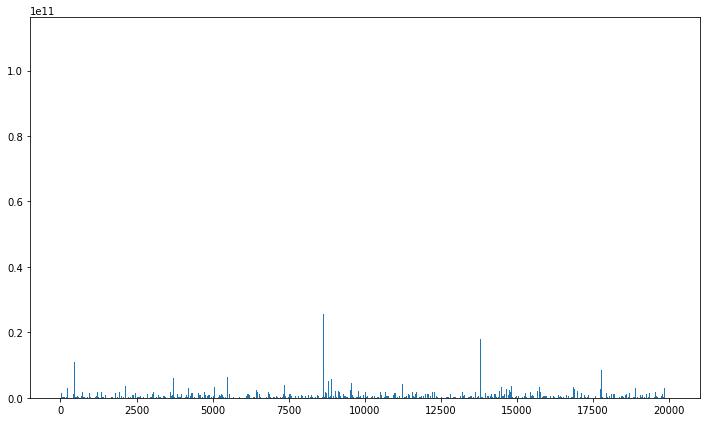

In [ ]:
#plot train_loss1 vs i in basiclin1
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(12,7))
n = 20000
X = np.arange(n)+1 #X是1,2,3,4,5,6,7,8,柱的个数
Y1 = train_loss1_np
# plt.bar(X, Y1, alpha=0.9, width = 0.35, facecolor = 'lightskyblue', edgecolor = 'white', label='one', lw=1)
plt.bar(X, Y1)



loss in autoencoder 1 

In [ ]:
# training to reduce dimsension of first cache
epoch_dim = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(encoderdecoder1.parameters(),lr=0.1)
train_loss2 = []
lr = 0.0025
weight_decay = 0
print('Training on autoencoder2 beginning...')
start_time = time.time()

for epoch in range(epoch_dim):
  for inputs in basiclin2: #the result from the first layer in basic network
    inputs = inputs.to(device)
    optimizer.zero_grad()
    output2 = encoderdecoder2(inputs)                  
    loss = criterion(output2, inputs)
    train_loss2.append(loss)
    loss.backward(retain_graph=True)
    optimizer.step() 

end_time = time.time()
print('Training on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')


    


Training beginning...
Training on 10 epochs done in  288.34115195274353  seconds


In [ ]:
train_loss2 = last_set(train_loss2,20000,1)
train_loss2_np = ten2num(train_loss2)

<BarContainer object of 20000 artists>

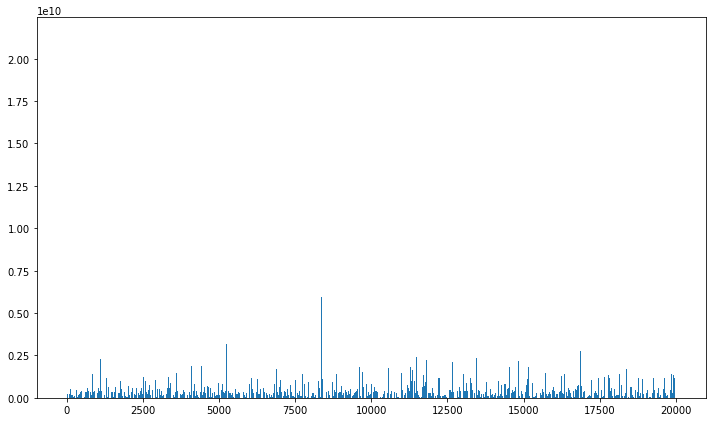

In [ ]:
#plot train_loss2 vs i in basiclin2
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(12,7))
n = 20000
X = np.arange(n)+1 #X是1,2,3,4,5,6,7,8,柱的个数
Y2 = train_loss2_np
# plt.bar(X, Y1, alpha=0.9, width = 0.35, facecolor = 'lightskyblue', edgecolor = 'white', label='one', lw=1)
plt.bar(X, Y2)



loss in autoencoder2

In [ ]:

cache1 = [] #empty list used to store the reduced dimension output from layer 1
cache2 = [] #empty list used to store the reduced dimension output from layer 2
#store the output from autoencoder 
#they are cache1_redu,cache2_redu

for data1 in basiclin1:
  redu_lin1 = encoderdecoder1.linear2(encoderdecoder1.linear1(data1))
  redu_output1 = Cache(redu_lin1)
  cache1 = redu_output1.store(cache1)

for data2 in basiclin2:
  redu_lin2 = encoderdecoder2.linear2(encoderdecoder2.linear1(data2))
  redu_output2 = Cache(redu_lin2)
  cache2 = redu_output2.store(cache2)







In [ ]:
# convert data in cache1,2 from tensor to numpy 
cache1 = ten2num(cache1)
cache2 = ten2num(cache2)
cache_label = ten2num(split(last_set(cache_label)))



code above is  offline phase, the code below is incomplete and is used for freezing.

In [ ]:
testmodel = BasicNet(num_features, 2).to(device)
test_accuracy = []
train_loss = []
nbr_epochs = 10
lr = 0.0025
weight_decay = 0
test_cache_label = [] #empty list used to store label of each test data
test_interlin1 = [] #empty list used to store intermediate test output from first layer
test_interlin2 = [] #empty list used to store intermediate test output from second layer

# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
# optimizer = optim.SGD(model.parameters(), lr=lr ,weight_decay=weight_decay)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)


print('Testing beginning...')
start_time = time.time()
for epoch in range(1, nbr_epochs+1):
    print('Epoch ', epoch, ':')
    for inputs, target in pre_model.valid_loader:
      inputs, target = inputs.to(device), target.to(device)
      optimizer.zero_grad()
      output = testmodel(inputs)  
      test_cache_label.append(target)
      loss = loss_fn(output[3], target)
      loss.backward(retain_graph=True)
      optimizer.step()
      ######### store output
      test_inter_output = Inter_output(output[1],output[2])
      testlin1,testlin2 = test_inter_output.store(test_interlin1,test_interlin2)


    
end_time = time.time()
print('Testing on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')

In [ ]:
#take out the last set of  intermediate output
test_last_lin1 = last_set(testlin1,20000,1000)
test_last_lin2 = last_set(testlin2,20000,1000)


In [ ]:
# training to reduce dimsension of first cache
epoch_dim = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(encoderdecoder1.parameters(),lr=0.01)
cache3 = [] #empty list used to store the reduced dimension test output from layer 1
cache4 = [] #empty list used to store the reduced dimension test output from layer 2

for epoch in range(epoch_dim):
  running_loss = 0.0
  for i in test_last_lin1: #the result from the first layer in basic network
    inputs = i.to(device)
    optimizer.zero_grad()
    output3 = encoderdecoder1(inputs)                       
    loss = criterion(output3[0], inputs)
    loss.backward(retain_graph=True)
    running_loss += loss.item() 

    ##store the reduced dimension output from first layer of basic network
    cache_dim3 = Cache(output3[1])
    cache_dim3.store(cache3)
      


    
print('Finish Training encoderdecoder1 process')


Finish Training encoderdecoder1 process


In [ ]:
# training to reduce dimsension of first cache
epoch_dim = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(encoderdecoder2.parameters(),lr=0.01)

for epoch in range(epoch_dim):
  running_loss = 0.0
  for i in test_last_lin2:
    inputs = i.to(device)
    optimizer.zero_grad()
    output4 = encoderdecoder2(inputs)
    loss = criterion(output4[0], inputs)
    loss.backward(retain_graph=True)
    running_loss += loss.item()

    ##store the reduced dimension output from second layer of basic network
    cache_dim4 = Cache(output4[1])
    cache_dim4.store(cache4)

    
print('Finish Training encoderdecoder2 process')


Finish Training encoderdecoder2 process


In [ ]:
#take last set of this test output
cache3 = last_set(cache3,10000,1000)
cache4 = last_set(cache4,10000,1000)
#convert the reduced dimension test output from layer1&layer2 to numpy individually
cache3 = ten2num(cache3)
cache4 = ten2num(cache4)



In [ ]:

cache1 = normalize(cache1)
cache2 = normalize(cache2)
cache3 = normalize(cache3)
cache4 = normalize(cache4)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh_layer1 = NearestNeighbors(n_neighbors=5) # 5 nearest neighbor
neigh_layer1.fit(cache1) #train first layer cache
neigh_layer1_list = [] # an empty list used to store the imformation of neighbors of data in cache3
for i in range(len(cache3)):
  neigh_layer1_list.append(neigh_layer1.kneighbors([cache3[i]]))
# length of neigh_layer1_list is 10000，each has 2 elements，first is the distance of data in cache3，second is their indices in cache1




In [ ]:
times0 = 0
times1 = 0
list_confidence0 = []
list_confidence1 = []
distance0 = 0
distance1 = 0
#initialize
for i in range(len(neigh_layer1_list)):
  for j in range(5):
    if cache_label[neigh_layer1_list[i][1][0][j]] == 1:
       times1 = times1 + 1
       distance1 = distance1 + 1/neigh_layer1_list[i][0][0][j]
    if cache_label[neigh_layer1_list[i][1][0][j]] == 0:
       times0 = times0 + 1
       distance0 = distance0 + 1/neigh_layer1_list[i][0][0][j]
  confidence0 = times0/5*distance0
  confidence1 = times1/5*distance1
  list_confidence0.append(confidence0)
  list_confidence1.append(confidence1)
  #delete to 0
  confidence0 = 0
  confidence1 = 0
  distance0 = 0
  distance1 = 0
  times0 = 0
  times1 = 0


In [ ]:
con_label = []
for i in range(len(list_confidence0)):
  if list_confidence0[i] > list_confidence1[i]:
    con_label.append([list_confidence0[i],"0"])
  if list_confidence0[i] < list_confidence1[i]:
    con_label.append([list_confidence1[i],"1"])


  

In [ ]:
len(con_label)

10000

In [ ]:
con_label